In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
print(tf.__version__)

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

2.12.0


In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kasireddysaisnigdha","key":"02db530b4f7986fa338c0a53d7884eb3"}'}

In [3]:

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 53.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.9MB/s]


In [5]:

!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:

for dirpath,dirnames,filenames in os.walk("/content/chest_xray"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 5 directories and 0 images in '/content/chest_xray'.
there are 2 directories and 0 images in '/content/chest_xray/val'.
there are 0 directories and 8 images in '/content/chest_xray/val/PNEUMONIA'.
there are 0 directories and 8 images in '/content/chest_xray/val/NORMAL'.
there are 1 directories and 1 images in '/content/chest_xray/__MACOSX'.
there are 3 directories and 3 images in '/content/chest_xray/__MACOSX/chest_xray'.
there are 2 directories and 1 images in '/content/chest_xray/__MACOSX/chest_xray/val'.
there are 0 directories and 9 images in '/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA'.
there are 0 directories and 9 images in '/content/chest_xray/__MACOSX/chest_xray/val/NORMAL'.
there are 2 directories and 3 images in '/content/chest_xray/__MACOSX/chest_xray/train'.
there are 0 directories and 3876 images in '/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA'.
there are 0 directories and 1342 images in '/content/chest_xray/__MACOSX/chest_xray/train/NORMA

In [7]:
import pathlib
data_dir = pathlib.Path("/content/chest_xray")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names


array(['__MACOSX', 'chest_xray', 'test', 'train', 'val'], dtype='<U10')

/content/chest_xray/chest_xray/


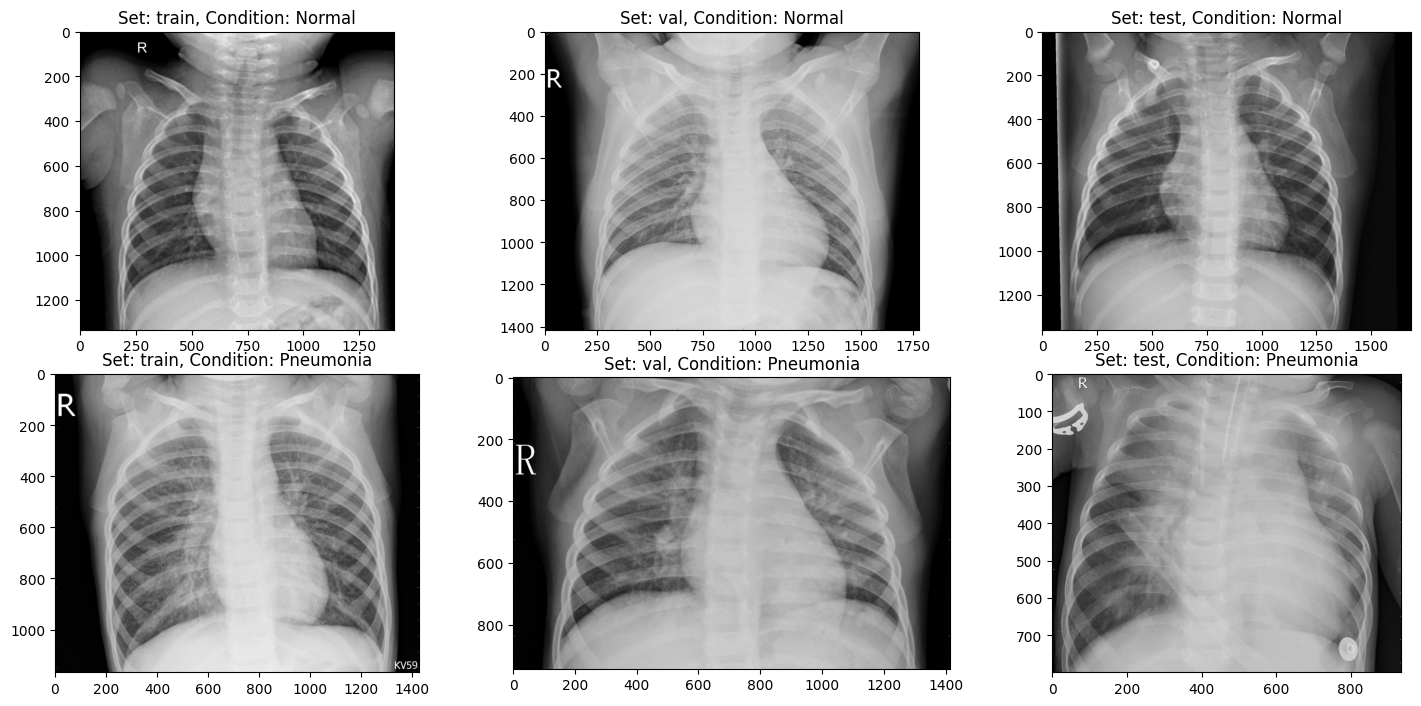

In [8]:
import os
import matplotlib.pyplot as plt

input_path = '/content/chest_xray/chest_xray/'
print(input_path)

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(input_path, _set)
    normal_path = os.path.join(set_path, 'NORMAL')
    pneumonia_path = os.path.join(set_path, 'PNEUMONIA')

    ax[i].imshow(plt.imread(os.path.join(normal_path, os.listdir(normal_path)[0])), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(os.path.join(pneumonia_path, os.listdir(pneumonia_path)[0])), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

plt.show()


In [9]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [10]:
input_path = '/content/chest_xray/chest_xray/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)


    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [11]:
img_dims = 150
epochs = 5
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [13]:
# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size,
           epochs=epochs, validation_data=test_gen,
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

<ipython-input-13-4812e868c216>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 392s 2s/step - loss: 0.3787 - accuracy: 0.8200 - val_loss: 0.7286 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/5
163/163 [==============================] - 379s 2s/step - loss: 0.2995 - accuracy: 0.8668 - val_loss: 0.7110 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/5
163/163 [==============================] - 371s 2s/step - loss: 0.2760 - accuracy: 0.8850 - val_loss: 0.9782 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/5
163/163 [==============================] - 380s 2s/step - loss: 0.2551 - accuracy: 0.8980 - val_loss: 1.4029 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 5/5
163/163 [==============================] - 374s 2s/step - loss: 0.2275 - accuracy: 0.9162 - val_loss: 1.3826 - val_accuracy: 0.3766 - lr: 0.0010


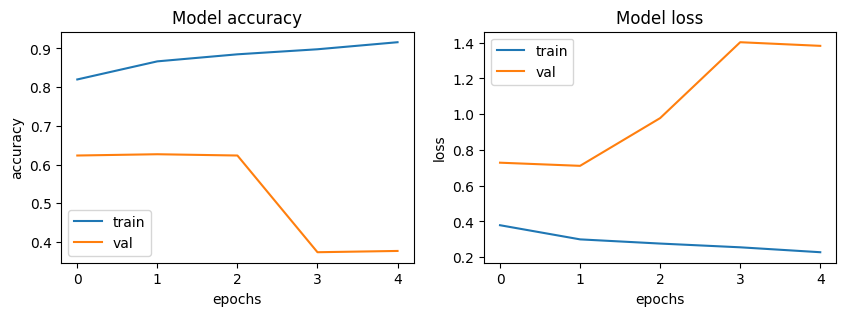

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:



from tensorflow.keras.preprocessing import image
img = image.load_img(r"/content/tocheck2.jpeg", target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_batch = np.expand_dims(img_array, axis=0)


preds = model.predict(img_batch)
print(preds)

if preds[0][0] >0.5:
    print(" The Person is affected by Pneumonia")
else:
    print(" The Person is in Normal Condition")




1/1 [==============================] - 0s 177ms/step
[[0.7711995]]
 The Person is affected by Pneumonia


In [17]:
!pip install gradio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [18]:
import gradio as gr

In [29]:
import numpy as np
import tensorflow as tf
from keras.models import load_model, save_model
from tensorflow.keras.preprocessing import image
import gradio as gr

# Define the model architecture
def create_model():
    # ... Define your model architecture here ...
    return model

# Load the trained model or create a new one
try:
    model = load_model('saved_model.h5')
except:
    model = create_model()
    # ... Train your model or load pre-trained weights here ...
    save_model(model, 'saved_model.h5')

# Define the pneumonia prediction function
def pneumoniaPrediction(img):
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_batch)
    if preds[0][0] > 0.5:
        return "The Person is affected by Pneumonia"
    else:
        return "The Person is in Normal Condition"

# Define the Gradio interface
img = gr.inputs.Image(shape=(150, 150))
label = gr.outputs.Label()

# Customize the interface appearance
iface = gr.Interface(fn=pneumoniaPrediction,
                     inputs=img,
                     outputs=label,
                     title="Pneumonia Detection using Chest X-Ray",
                     theme="light",  # Choose from "default", "light", "dark", "huggingface"
                     layout="vertical",  # Choose from "vertical", "horizontal", "unaligned"
                     description="Upload an image of a chest X-ray to predict if the person has pneumonia.")

# Launch the Gradio interface
iface.launch(debug=True)


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:680: UserWarning: Cannot load light. Caught Exception: The space light does not exist
  warnings.warn(f"Cannot loa

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!mv * /content/drive/MyDrive/Your_Project_Folder/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
from google.colab import files

# Download a file
files.download('pneumonia')


FileNotFoundError: ignored